Train HOG Classifier
===


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from lesson_functions import *
from sklearn.utils import shuffle

### Load splitted data sets from pickle file

In [2]:
# Load the training validation and test data
data_file = 'data.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
cars = data['cars']
notcars = data['notcars']

### Two classes are quite balanced

In [3]:
print('Number of samples in cars set: ', len(cars))
print('Number of samples in notcars set: ', len(notcars))

Number of samples in cars set:  8792
Number of samples in notcars set:  8968


### Extract features from image files 

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, params):
                     
    color_space    = params['color_space']
    spatial_size   = params['spatial_size']
    hist_bins      = params['hist_bins']
    orient         = params['orient']
    pix_per_cell   = params['pix_per_cell']
    cell_per_block = params['cell_per_block']
    hog_channel    = params['hog_channel']
    spatial_feat   = params['spatial_feat']
    hist_feat      = params['hist_feat']
    hog_feat       = params['hog_feat']
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img = mpimg.imread(file)
        
        img_features = single_img_features(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    
        features.append(img_features)
        
    # Return list of feature vectors
    return features

In [2]:
params = {}

params['color_space'] = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
params['orient'] = 9  # HOG orientations
params['pix_per_cell'] = 8 # HOG pixels per cell
params['cell_per_block'] = 2 # HOG cells per block
params['hog_channel'] = 'ALL' # Can be 0, 1, 2, or "ALL"
params['spatial_size'] = (32, 32) # Spatial binning dimensions
params['hist_bins'] = 32    # Number of histogram bins
params['spatial_feat'] = True # Spatial features on or off
params['hist_feat'] = True # Histogram features on or off
params['hog_feat'] = True # HOG features on or off

#params['color_space'] = 'HLS'#YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#params['orient'] = 9  # HOG orientations
#params['pix_per_cell'] = 8 # HOG pixels per cell
#params['cell_per_block'] = 2 # HOG cells per block
#params['hog_channel'] = 'ALL' # Can be 0, 1, 2, or "ALL"
#params['spatial_size'] = (16, 16) # Spatial binning dimensions
#params['hist_bins'] = 32    # Number of histogram bins
#params['spatial_feat'] = True # Spatial features on or off
#params['hist_feat'] = True # Histogram features on or off
#params['hog_feat'] = True # HOG features on or off

t1=time.time()

cars_feats = extract_features(cars, params)
notcars_feats = extract_features(notcars, params)

t2 = time.time()
print(round(t2-t1, 2), 'second to extract features (HOG,spatial and color features).')

NameError: name 'extract_features' is not defined

In [6]:
assert(len(cars_feats) == len(cars))
assert(len(notcars_feats) == len(notcars))

### Combine and Normalize Features

In [7]:
# Create an array stack of feature vectors
X = np.vstack((cars_feats, notcars_feats)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

(17760, 8460)


### Split up data into randomized training and test sets

In [8]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Number of samples in train set: ', len(X_train))
print('Number of samples in test set: ', len(X_test))

Number of samples in train set:  14208
Number of samples in test set:  3552


### Save prepared train and test sets to pickle file

In [9]:
# Save the data for easy access
def save_classifier_data(pickle_file, X_train, y_train, X_test, y_test):
    print('Saving features/labels to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'X_train': X_train,
                    'y_train': y_train,
                    'X_test': X_test,
                    'y_test': y_test                
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save classifier data to', pickle_file, ':', e)
        raise
    print('Classifier data cached in pickle file.')

In [10]:
save_classifier_data('HOGClassifierData.p', X_train, y_train, X_test, y_test)

Saving features/labels to pickle file...
Classifier data cached in pickle file.


### Train SVM Classifier

In [11]:
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 8460
68.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  1.
  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.
  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
For these 100 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  1.
  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  1.
  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.]
0.06909 Seconds to predict 100 labels with SVC


### Save HOG Classifier to file

In [12]:
def save_classifier(pickle_file, svc, X_scaler, params):
    print('Saving classiifier to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {   'svc':svc, 
                    'scaler': X_scaler,

                    'color_space': params['color_space'],
                    'orient': params['orient'],
                    'pix_per_cell': params['pix_per_cell'],
                    'cell_per_block': params['cell_per_block'],
                    'hog_channel': params['hog_channel'],
                    'spatial_size': params['spatial_size'],
                    'hist_bins': params['hist_bins'],
                    'spatial_feat': params['spatial_feat'],
                    'hist_feat': params['hist_feat'],
                    'hog_feat': params['hog_feat']
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save classifier to', pickle_file, ':', e)
        raise
    print('Classifier saved in pickle file.')

In [13]:
save_classifier('HOGClassifier.p', svc, X_scaler, params)

Saving classiifier to pickle file...
Classifier saved in pickle file.


### Test prediction

color_space:  YCrCb
orient:  9
pix_per_cell:  8
cell_per_block:  2
hog_channel:  ALL
spatial_size:  (32, 32)
hist_bins:  32
spatial_feat:  True
hist_feat:  True
hog_feat:  True
0.48558 Seconds to detect using scale: 1.5


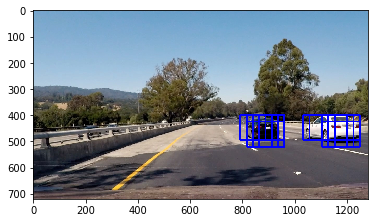

In [15]:
from find_cars import find_cars
%matplotlib inline

dist_pickle = pickle.load( open("HOGClassifier.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
#orient = dist_pickle["orient"]
#pix_per_cell = dist_pickle["pix_per_cell"]
#cell_per_block = dist_pickle["cell_per_block"]
#spatial_size = dist_pickle["spatial_size"]
#hist_bins = dist_pickle["hist_bins"]

params = {}
params['color_space']    = dist_pickle['color_space']
params['orient']         = dist_pickle['orient']
params['pix_per_cell']   = dist_pickle['pix_per_cell']
params['cell_per_block'] = dist_pickle['cell_per_block']
params['hog_channel']    = dist_pickle['hog_channel']
params['spatial_size']   = dist_pickle['spatial_size']
params['hist_bins']      = dist_pickle['hist_bins']
params['spatial_feat']   = dist_pickle['spatial_feat']
params['hist_feat']      = dist_pickle['hist_feat']
params['hog_feat']       = dist_pickle['hog_feat']

print('color_space: ', params['color_space'])
print('orient: ', params['orient'])
print('pix_per_cell: ', params['pix_per_cell'])
print('cell_per_block: ', params['cell_per_block'])
print('hog_channel: ', params['hog_channel'])
print('spatial_size: ', params['spatial_size'])
print('hist_bins: ', params['hist_bins'])
print('spatial_feat: ', params['spatial_feat'])
print('hist_feat: ', params['hist_feat'])
print('hog_feat: ', params['hog_feat'])

#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('test_images/test5.jpg')
#img = mpimg.imread('test_images/test6.jpg')

ystart = 400
ystop = 656
scale = 1.5
    
t=time.time()

draw_img = np.copy(img)
img = img.astype(np.float32)/255
bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, params)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to detect using scale:', scale)

draw_img = draw_boxes(draw_img, bboxes)

plt.imshow(draw_img)


0.25383 Seconds to detect
2 cars found


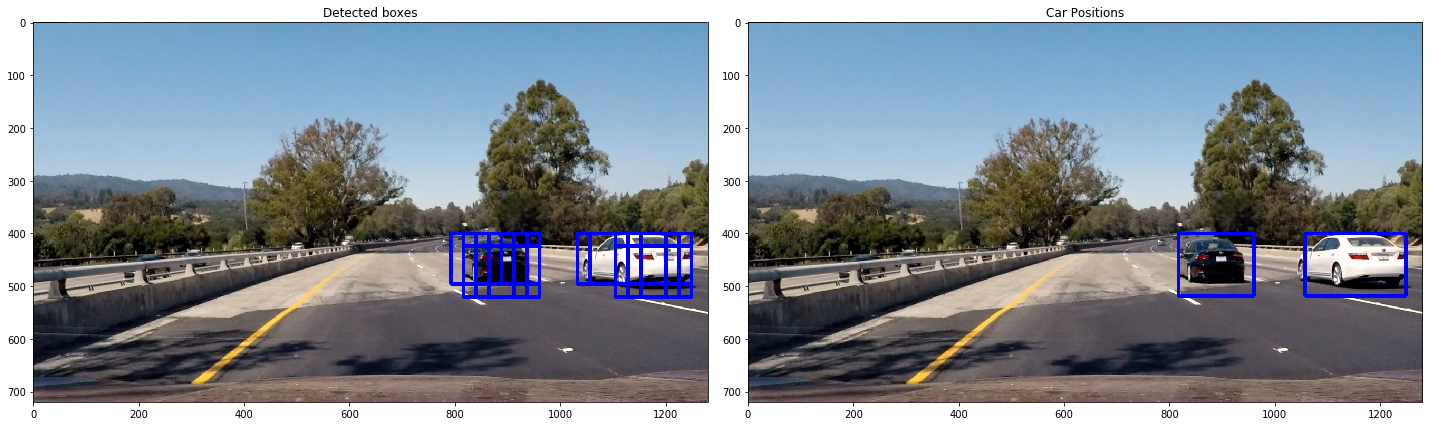

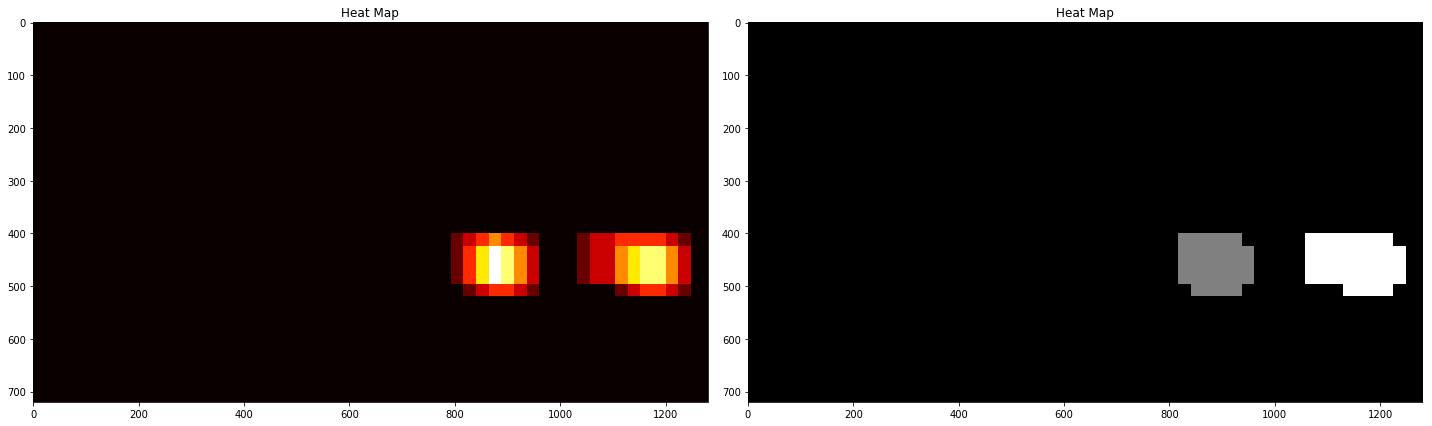

In [2]:
from find_cars import load_classifier, find_cars_multiscale, detect_vehicles
from scipy.ndimage.measurements import label
%matplotlib inline

load_classifier()

#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('test_images/test5.jpg')
#img = mpimg.imread('test_images/test6.jpg')

t=time.time()
bboxes = find_cars_multiscale(img, verbose=False)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to detect')

bboxes, hot_windows, heatmap, labels = detect_vehicles(img, 0, verbose=True)

print(len(bboxes), 'cars found')

draw_img1 = draw_boxes(img, hot_windows)
draw_img2 = draw_boxes(img, bboxes)

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(draw_img1)
plt.title('Detected boxes')

plt.subplot(122)
plt.imshow(draw_img2)
plt.title('Car Positions')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

plt.subplot(122)
plt.imshow(labels[0], cmap='gray')
plt.title('Heat Map')
fig.tight_layout()
plt.show()